In [1]:
%pip install pandas numpy matplotlib tabulate

Note: you may need to restart the kernel to use updated packages.


,Mean,Std (S),Std (P),Min,Q1,Median,Q3,Max,Sum,CV,ΔMean (%)
ark0f_default,342.6,47.4,47.4,289.5,321.6,336.6,362.9,"2,110.3","994,579.1",0.138,-0.1%
ark0f_g4_m0,289.0,36.6,36.6,269.3,270.8,273.1,290.6,"1,242.4","838,950.3",0.127,-15.7%
ark0f_g8_m0,289.1,36.9,36.9,269.3,270.8,273.1,290.6,"1,242.4","839,325.9",0.128,-15.7%
ark0f_granularity_half,307.4,55.5,55.5,269.3,272.2,273.1,336.5,"2,126.5","892,305.6",0.181,-10.4%
ark0f_granularity_one_eighth,289.1,36.9,36.9,269.3,270.8,273.1,290.6,"1,242.4","839,333.1",0.128,-15.7%
ark0f_granularity_quarter,289.0,36.6,36.6,269.3,270.8,273.1,290.6,"1,242.4","838,957.5",0.127,-15.7%
ark0f_max_release_check_rate_0,342.6,47.4,47.4,289.5,321.6,336.6,362.9,"2,110.3","994,571.9",0.138,-0.1%
ark0f_max_release_check_rate_max,342.6,47.4,47.4,289.5,321.6,336.6,362.9,"2,110.3","994,583.9",0.138,-0.1%
ark0f_trim_threshold_0,342.6,47.4,47.4,289.5,321.6,336.6,362.9,"2,110.4","994,579.2",0.138,-0.1%
ark0f_trim_threshold_max,342.6,47.4,47.4,289.5,321.6,336.6,362.9,"2,110.3","994,579.1",0.138,-0.1%


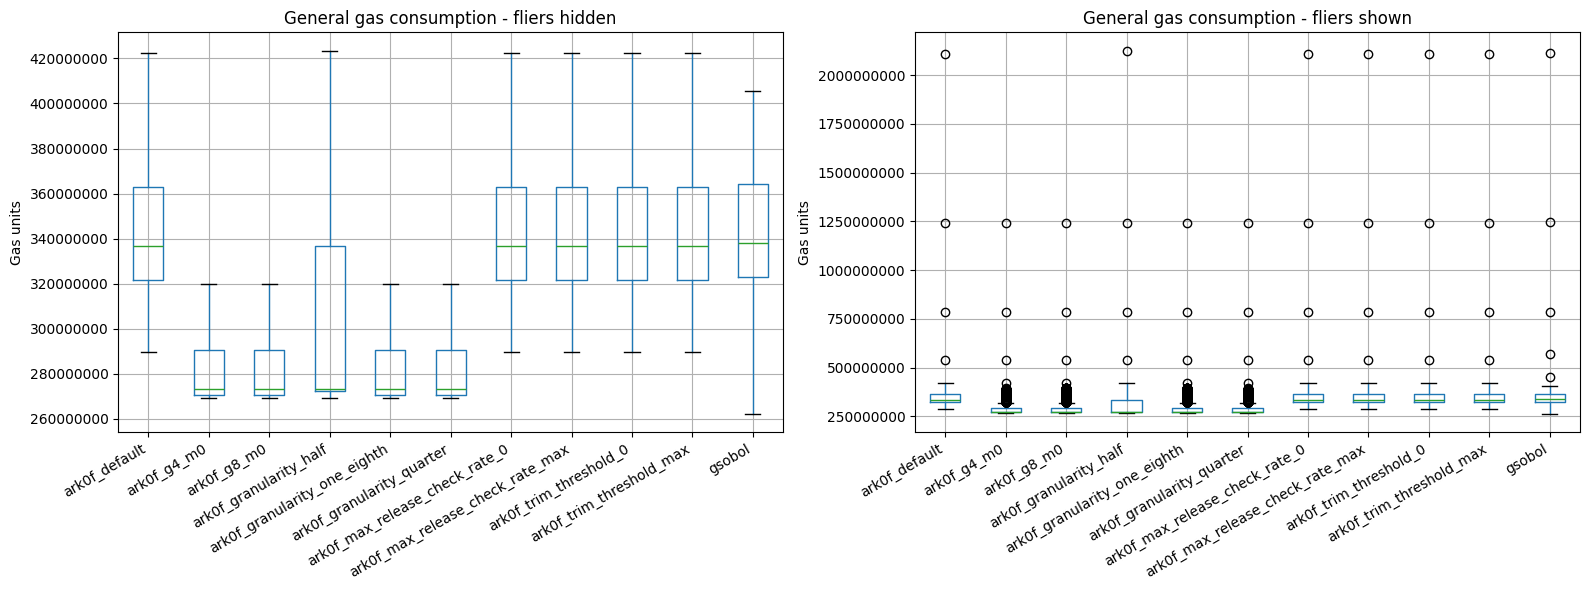

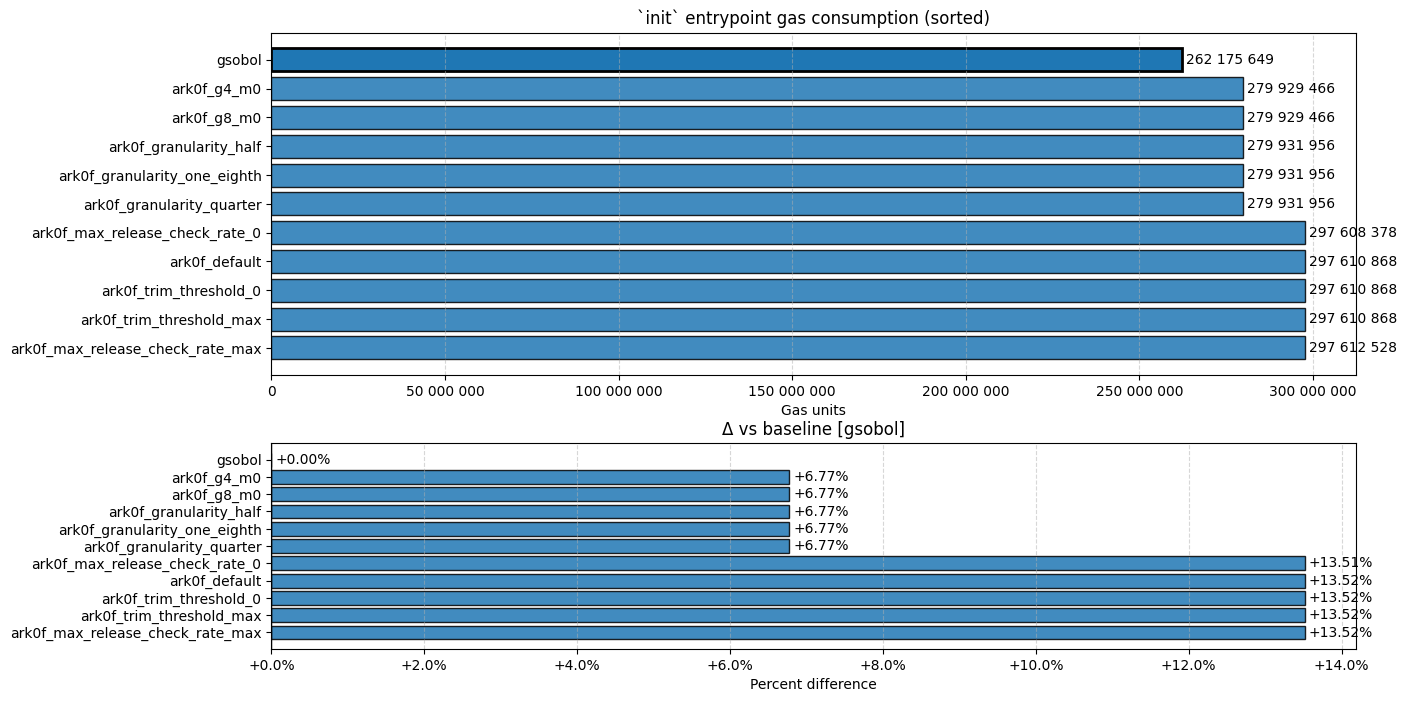

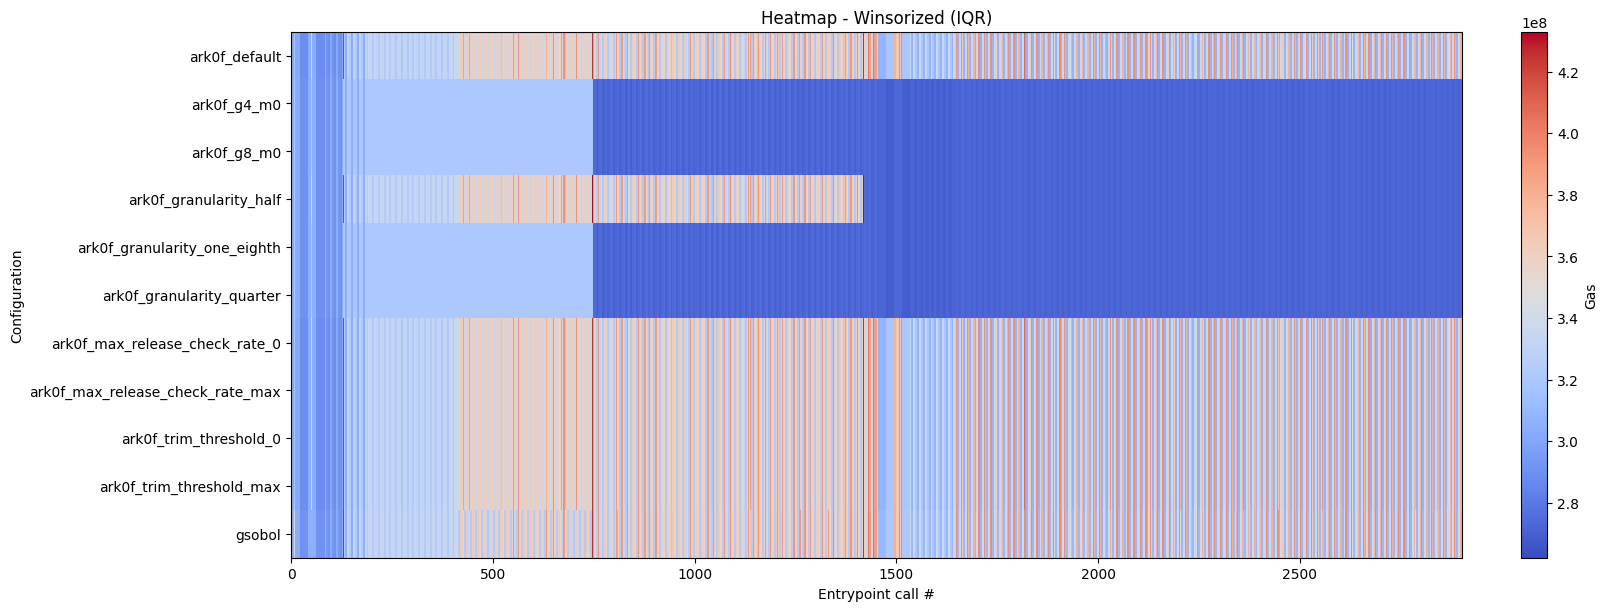

In [9]:
import os
import re
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import numpy as np
import math
from IPython.display import display

BASELINE = "gsobol"
VALUE_PER_GAS = 100
GAS_PER_US = 1_000_000

files = glob.glob("results/*.log")
if not files:
    raise SystemExit("No files matched")
files = sorted(files)

rx = re.compile(r"Value burned for `(init|handle)`: *(?P<gas>\d+)")
def extract_value_numbers(path: str) -> list[int]:
    out = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if (m := rx.search(line)):
                out.append(int(m["gas"]))
    return out

names = [Path(f).stem for f in files]
prefix = os.path.commonprefix(names)
labels = [n[len(prefix):] for n in names]

data = {label: pd.Series(extract_value_numbers(f), dtype="Int64") 
        for f, label in zip(files, labels)}

df = pd.DataFrame(data).astype("Float64").div(VALUE_PER_GAS)

def _winsorize_df(df: pd.DataFrame, k: float = 1.5) -> pd.DataFrame:
    df_num = df.apply(pd.to_numeric, errors="coerce").astype("float64")
    q1 = df_num.quantile(0.25)
    q3 = df_num.quantile(0.75)
    iqr = q3 - q1
    lower = (q1 - k * iqr).fillna(-np.inf)
    upper = (q3 + k * iqr).fillna(np.inf)
    return df_num.clip(lower=lower, upper=upper, axis=1)

def table():
    desc = df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
    desc = desc.rename(columns={"std": "std_samp", "50%": "median"})
    desc = desc.drop(columns=['count'])
    
    # Add a few extras
    desc["std_pop"] = df.std(ddof=0)                # population std
    desc["sum"] = df.sum()
    desc["cv"] = df.std(ddof=1) / df.mean()         # coefficient of variation
    
    # Reorder/round columns for a tidy view
    cols = ["mean", "std_samp", "std_pop", "min", "25%", "median", "75%", "max", "sum", "cv"]
    stats = desc[cols].round(3)

    nice = stats.copy()
    scale_cols = ['mean', 'std_samp', 'std_pop', 'min', '25%', 'median', '75%', 'max', 'sum']
    nice[scale_cols] = nice[scale_cols] / GAS_PER_US
    
    # Rename & order columns
    nice = nice.rename(columns={
        'mean':'Mean', 'std_samp':'Std (S)', 'std_pop':'Std (P)',
        'min':'Min', '25%':'Q1', 'median':'Median', '75%':'Q3', 'max':'Max',
        'sum':'Sum', 'cv':'CV'
    })
    
    # Add delta to a baseline
    baseline_mean = stats.loc[BASELINE, 'mean']
    nice['ΔMean (%)'] = (stats['mean'] - baseline_mean) / baseline_mean * 100
    
    # Pretty formatting (thousands separators, fixed decimals)
    fmt = {
        'Mean': '{:,.1f}', 'Std (S)': '{:,.1f}', 'Std (P)': '{:,.1f}',
        'Min': '{:,.1f}', 'Q1': '{:,.1f}', 'Median': '{:,.1f}',
        'Q3': '{:,.1f}', 'Max': '{:,.1f}', 'Sum': '{:,.1f}',
        'CV': '{:.3f}', 'ΔMean (%)': '{:+.1f}%'
    }
    
    styled = (nice.style
        .format(fmt)
        .set_caption('Summary - values in microseconds (µs)')
        .set_properties(**{'text-align':'right', 'white-space':'nowrap'})
        # Helpers for scanning
        .background_gradient(subset=['Mean','Median'], cmap='Blues')
        .bar(subset=['ΔMean (%)'], align='mid') if 'ΔMean (%)' in nice.columns else nice.style.format(fmt)
    )
    with open("stats.html", "w", encoding="utf-8") as f:
        f.write(styled.to_html())
    display(styled)

def boxplot_graph():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left: fliers hidden
    df.boxplot(ax=axes[0], showfliers=False)
    axes[0].set_title("General gas consumption - fliers hidden")

    # Right: fliers shown (default)
    df.boxplot(ax=axes[1], showfliers=True)
    axes[1].set_title("General gas consumption - fliers shown")

    for ax in axes:
        ax.set_ylabel("Gas units")
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
        ax.ticklabel_format(axis="y", style="plain")  # plain numbers, not 1e6
        ax.tick_params(axis="x", labelrotation=30)
        for lbl in ax.get_xticklabels():
            lbl.set_ha("right")

    plt.tight_layout()
    plt.savefig("boxplot.png", dpi=200)
    plt.show()

def init_entrypoint_graph():
    first_values = df.iloc[0]  # Series
    baseline = first_values[BASELINE]
    
    # --- order by absolute value (ascending) ---
    vals = first_values.sort_values()
    labels = vals.index
    rel_pct = (vals / baseline - 1.0) * 100.0  # % vs baseline
    
    # formatters
    fmt_int = FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", " "))
    fmt_pct = FuncFormatter(lambda x, _: f"{x:+.1f}%")
    
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(14, 8),
        gridspec_kw={"height_ratios": [2.0, 1.2], "hspace": 0.25},
    )
    
    # ========== Absolute (gas units) ==========
    bars1 = ax1.barh(labels, vals.values, edgecolor="black", alpha=0.85)
    ax1.set_title("Program upload gas consumption (sorted)")
    ax1.set_xlabel("Gas units")
    ax1.xaxis.set_major_formatter(fmt_int)
    ax1.grid(axis="x", linestyle="--", alpha=0.5)
    ax1.invert_yaxis()  # smallest at top
    # absolute values
    ax1.bar_label(
        bars1,
        labels=[fmt_int(v) for v in vals.values],
        padding=3,           # gap from bar end
        clip_on=False,
    )

    # highlight baseline bar
    for b, lab in zip(bars1, labels):
        if lab == BASELINE:
            b.set_alpha(1.0)
            b.set_linewidth(2.0)
            break
    
    # ========== Relative (% vs baseline) ==========
    bars2 = ax2.barh(labels, rel_pct.values, edgecolor="black", alpha=0.85)
    ax2.set_title(f"Δ vs baseline [{BASELINE}]")
    ax2.set_xlabel("Percent difference")
    ax2.xaxis.set_major_formatter(fmt_pct)
    ax2.grid(axis="x", linestyle="--", alpha=0.5)
    ax2.axvline(0, color="black", linewidth=1)
    ax2.invert_yaxis()
    # percentages
    ax2.bar_label(
        bars2,
        labels=[f"{p:+.2f}%" for p in rel_pct.values],
        padding=3,
        clip_on=False,
    )

    plt.savefig("init_entrypoint.png", dpi=200, bbox_inches="tight")
    plt.show()

def heatmap():
    # numeric only, keep float for imshow
    df_num = df.apply(pd.to_numeric, errors="coerce").astype("float64")
    df_win = _winsorize_df(df_num)
    M_win  = df_win.to_numpy().T

    fig, ax = plt.subplots(figsize=(16, 6), constrained_layout=True)

    im = ax.imshow(M_win, aspect="auto", origin="upper", interpolation="nearest", cmap="coolwarm")
    ax.set_title("Heatmap - Winsorized (IQR)")
    ax.set_xlabel("Entrypoint call #")
    ax.set_ylabel("Configuration")
    ax.set_yticks(range(len(df_num.columns)))
    ax.set_yticklabels(df_num.columns)

    # Shared colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Gas")

    plt.savefig("heatmap.png", dpi=200)
    plt.show()

table()
boxplot_graph()
init_entrypoint_graph()
heatmap()
